In [1]:
!git clone https://github.com/kelvis24/new-simple-point-clouds.git

fatal: destination path 'new-simple-point-clouds' already exists and is not an empty directory.


In [2]:
pip install matplotlib

In [3]:
!pip install plyfile

In [4]:
pip install torch

In [5]:
pip install numpy torch trimesh open3d

In [6]:
!pip install rtree

In [7]:
import numpy as np
import torch
from plyfile import PlyData
import os

# Custom function to load point cloud data from binary .ply files
def load_point_cloud_from_ply(file_path):
    ply_data = PlyData.read(file_path)
    x = ply_data['vertex']['x']
    y = ply_data['vertex']['y']
    z = ply_data['vertex']['z']
    points = torch.tensor(np.column_stack((x, y, z)), dtype=torch.float32)
    return points

In [8]:
def resample_point_cloud(point_cloud, num_points):
    if len(point_cloud) == num_points:
        return point_cloud
    elif len(point_cloud) > num_points:
        indices = np.random.choice(len(point_cloud), size=num_points, replace=False)
        return point_cloud[indices]
    else:
        raise ValueError("Point cloud needs more points for resampling.")


In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to plot a single point cloud
def plot_point_cloud(points, title="Point Cloud", ax=None):
    if ax is None:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1)  # 's' is the size of each point
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    return ax

In [10]:
# Load all point clouds from the directory
point_clouds_directory = '/content/new-simple-point-clouds'
point_cloud_files = [f for f in os.listdir(point_clouds_directory) if f.endswith('.ply')]
point_clouds = [load_point_cloud_from_ply(os.path.join(point_clouds_directory, f)) for f in point_cloud_files]

# Find the number of points in the smallest point cloud
min_points = min(pc.shape[0] for pc in point_clouds)

# Resample all point clouds to match the smallest one
point_clouds = [resample_point_cloud(pc, min_points) for pc in point_clouds]

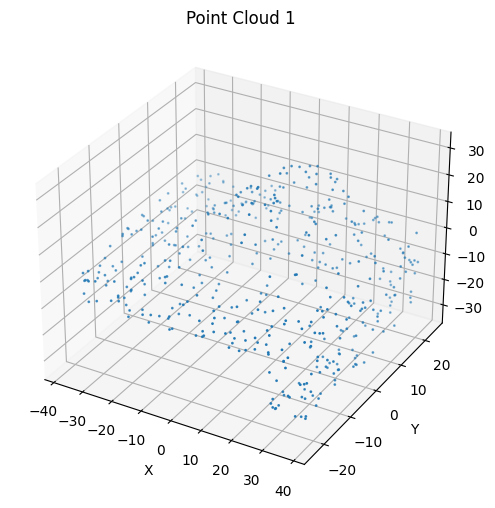

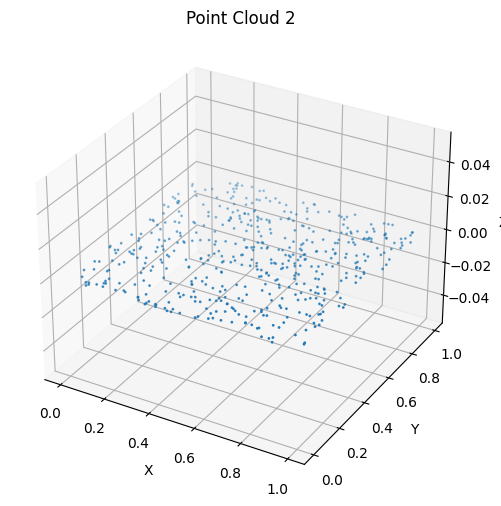

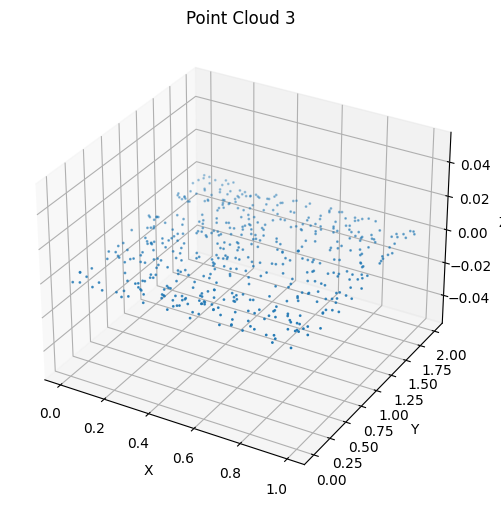

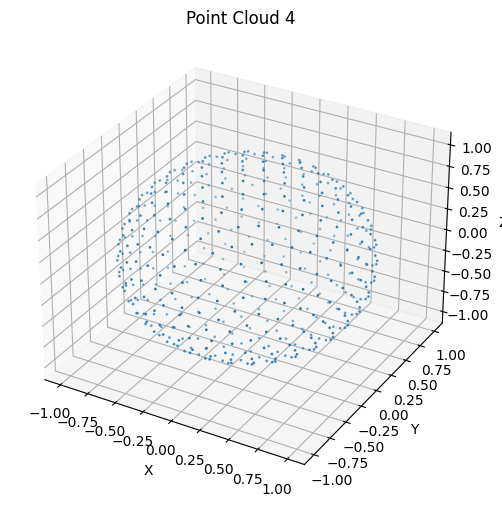

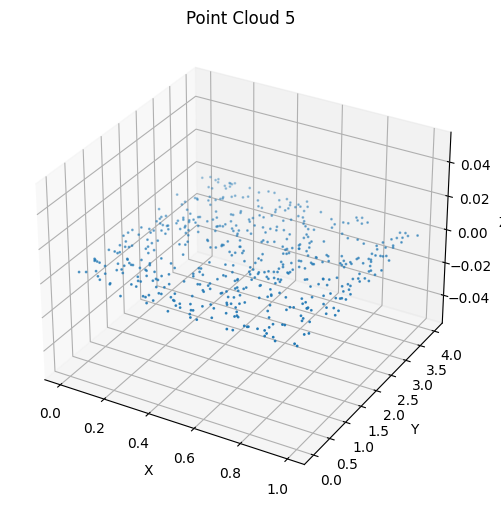

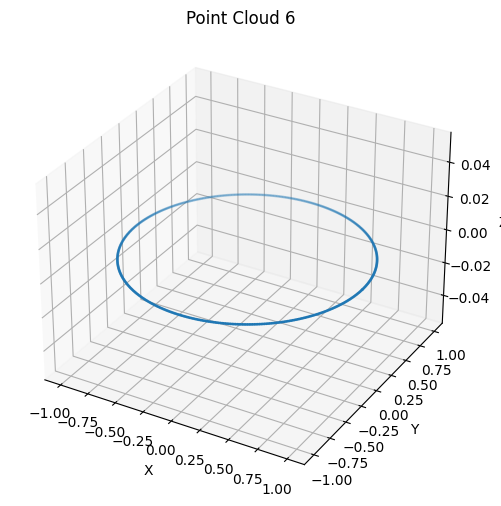

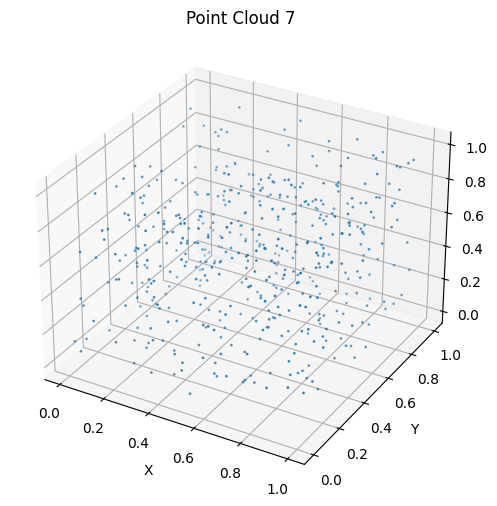

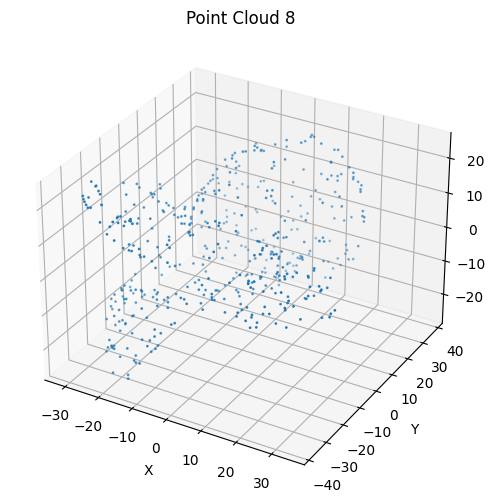

In [11]:
for i, point_cloud in enumerate(point_clouds):
    plot_point_cloud(point_cloud, title=f"Point Cloud {i + 1}")
    plt.show()

In [12]:
def visualize_with_marching_cubes(model, grid_size=50):
    # Generate a grid of points
    grid_points = np.linspace(-1, 1, grid_size)
    x, y, z = np.meshgrid(grid_points, grid_points, grid_points)
    grid_shape = x.shape
    xyz = torch.FloatTensor(np.stack([x.ravel(), y.ravel(), z.ravel()], axis=-1))

    # Normalize the points as done during training
    xyz_norm = (xyz - train_points_mean) / train_points_std

    # Predict SDF values for the grid
    with torch.no_grad():
        sdf_pred = model(xyz_norm).numpy().reshape(grid_shape)

    # Determine an appropriate level within the SDF value range
    sdf_min, sdf_max = sdf_pred.min(), sdf_pred.max()
    level = 0  # Default, but check if it's within range
    if level < sdf_min or level > sdf_max:
        print(f"Adjusting level from {level} to midpoint of SDF range.")
        level = sdf_min + (sdf_max - sdf_min) / 2

    # Marching Cubes to find surfaces
    verts, faces, _, _ = measure.marching_cubes(sdf_pred, level=level)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces])
    mesh.set_edgecolor('k')
    ax.add_collection3d(mesh)
    ax.set_xlim([0, grid_size])
    ax.set_ylim([0, grid_size])
    ax.set_zlim([0, grid_size])
    plt.tight_layout()
    plt.show()


In [27]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import trimesh
import open3d as o3d

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
        )

    def forward(self, x):
        return self.layers(x)

def eikonal_loss(sdf_values, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(sdf_values)
    grads = torch.autograd.grad(outputs=sdf_values, inputs=train_points,
                                grad_outputs=grad_outputs,
                                create_graph=True, retain_graph=True, only_inputs=True)[0]
    loss = torch.mean((grads.norm(2, dim=1) - 1) ** 2)
    return loss

def reconstruct_surface_mesh(point_cloud):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(point_cloud)
    pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
    distances = pcd.compute_nearest_neighbor_distance()
    avg_dist = np.mean(distances)
    radii = [avg_dist, avg_dist * 2]
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd, o3d.utility.DoubleVector(radii))
    return mesh

def prepare_sdf_training_data(mesh, num_samples=10000):
    vertices = np.asarray(mesh.vertices)
    faces = np.asarray(mesh.triangles)
    trimesh_mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
    bounds = trimesh_mesh.bounds
    sample_points = np.random.rand(num_samples, 3) * (bounds[1] - bounds[0]) + bounds[0]
    sdf_values = trimesh.proximity.signed_distance(trimesh_mesh, sample_points)
    return torch.tensor(sample_points, dtype=torch.float32), torch.tensor(sdf_values, dtype=torch.float32).unsqueeze(1)

def train_mlp_on_sdf_eikonal(model, train_points, train_sdf, epochs=10000, lr=0.0001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        train_points.requires_grad_(True)
        predictions = model(train_points)
        loss_eikonal = eikonal_loss(predictions)
        loss_sdf = torch.mean((predictions - train_sdf) ** 2)
        loss = loss_eikonal + loss_sdf
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")


# Load your point cloud
point_cloud_data = point_clouds[3]

# Reconstruct mesh and prepare SDF training data
mesh = reconstruct_surface_mesh(point_cloud_data)
train_points, train_sdf = prepare_sdf_training_data(mesh)

# Normalize train_points for better MLP training performance
train_points_mean = train_points.mean(0)
train_points_std = train_points.std(0) + 1e-8  # Add epsilon
train_points = (train_points - train_points_mean) / train_points_std

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.01)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

model.apply(init_weights)


# Initialize and train the MLP model with Eikonal Loss
model = MLP(input_dim=3, output_dim=1)
train_mlp_on_sdf_eikonal(model, train_points, train_sdf)


Epoch 0, Loss: 0.9434000253677368
Epoch 100, Loss: 0.6764117479324341
Epoch 200, Loss: 0.5811679363250732
Epoch 300, Loss: 0.5519436001777649
Epoch 400, Loss: 0.5415975451469421
Epoch 500, Loss: 0.5374234914779663
Epoch 600, Loss: 0.5366545915603638
Epoch 700, Loss: 0.5422931909561157
Epoch 800, Loss: 0.5482801198959351
Epoch 900, Loss: 0.5520828366279602
Epoch 1000, Loss: 0.5472766757011414
Epoch 1100, Loss: 0.5377432703971863
Epoch 1200, Loss: 0.528022289276123
Epoch 1300, Loss: 0.5183064937591553
Epoch 1400, Loss: 0.5099560618400574
Epoch 1500, Loss: 0.49881577491760254
Epoch 1600, Loss: 0.48820674419403076
Epoch 1700, Loss: 0.4858408570289612
Epoch 1800, Loss: 0.49065521359443665
Epoch 1900, Loss: 0.503309965133667
Epoch 2000, Loss: 0.5163280963897705
Epoch 2100, Loss: 0.5324872732162476
Epoch 2200, Loss: 0.5501059293746948
Epoch 2300, Loss: 0.567391574382782
Epoch 2400, Loss: 0.5795662999153137
Epoch 2500, Loss: 0.5770604014396667
Epoch 2600, Loss: 0.5800635814666748
Epoch 2700, L

10000 epochs for sphere below

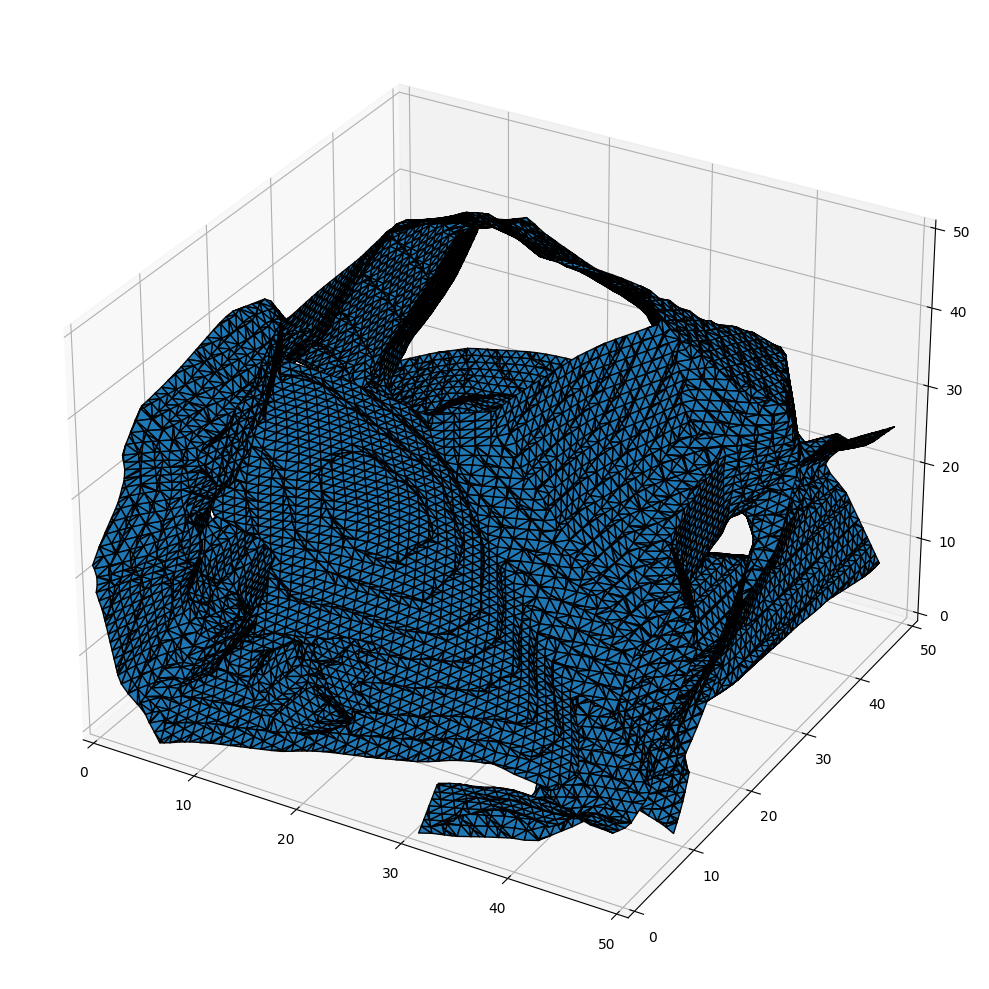

In [28]:
visualize_with_marching_cubes(model)

1000 epochs for sphere below

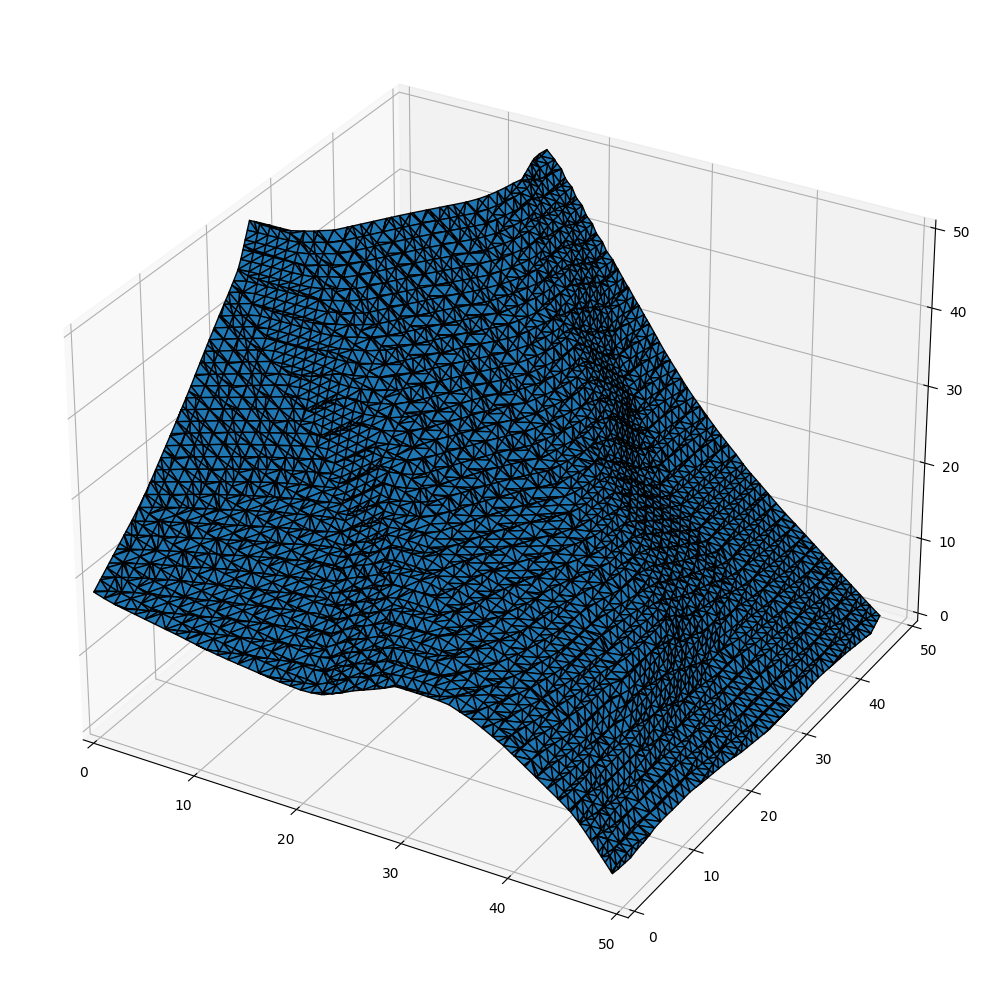

In [26]:
visualize_with_marching_cubes(model)

100 epochs for sheet below

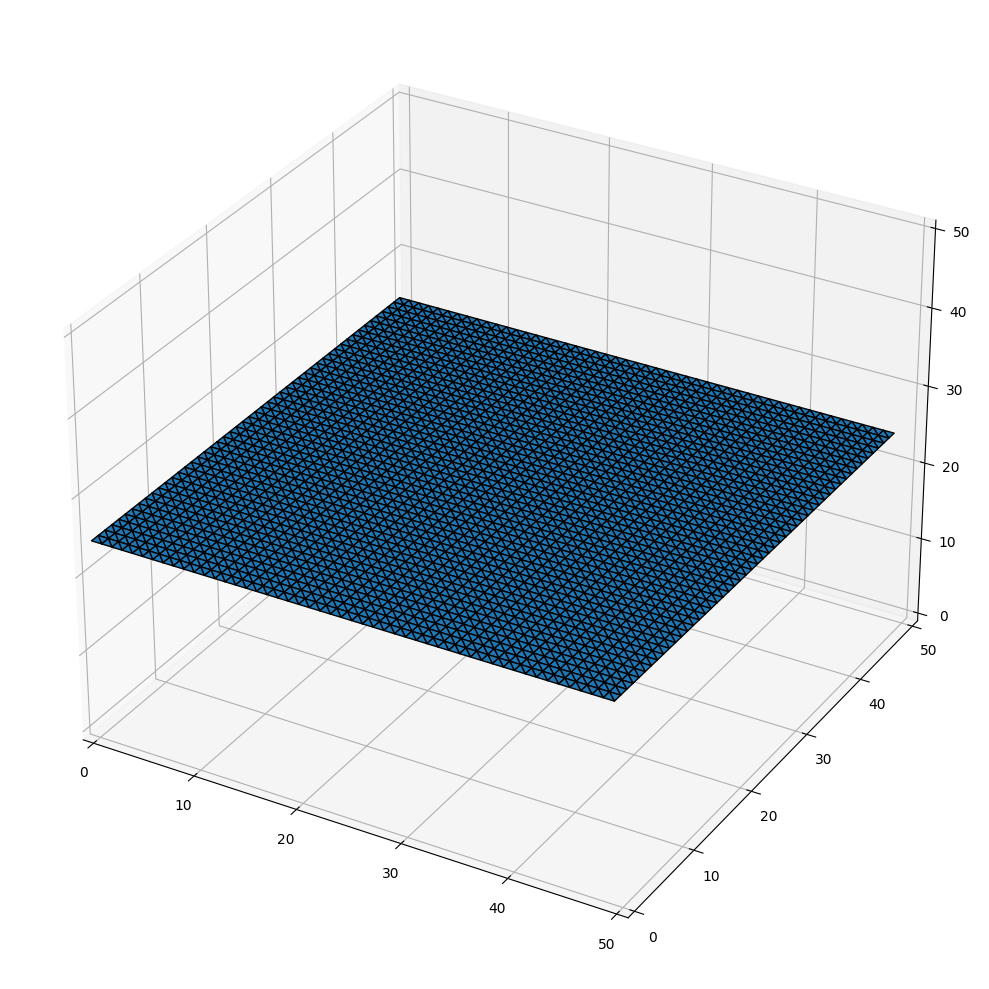

In [23]:
visualize_with_marching_cubes(model)